In [1]:
from sympy import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dynamics import Robot
# Enable the mathjax printer
init_printing(use_latex='mathjax')

## --> Definição do robô

In [2]:
# == Definir a Configuração == #
configuration = 'RRP'


# == Definir as Massas == #
m1, m2, m3 = Matrix(symbols(f'm_1:4'))
masses = Matrix([m1, 0, m3])            # massas: [m1, 0, m3] (m2 = 0)
L1, L2 = symbols('L_1 L_2')             # Comprimentos: L1 e L2


# == Definir as Inércias == #
# Inércias: [I1x, I1y, I1z],  I2 = 0, I3 = [I3x, I3y, I3z]
inertias = [diag(*symbols('I_1x:z')), diag(0,0,0), diag(*symbols('I_3x:z'))]


# == Definir os Centros de Massa (local) == #
# Centros de massa: [cm1, 0, cm3] (cm2 = 0)
cm1, cm2, cm3 = symbols(f'r_1:4')
r_cis = [Matrix([0, 0, cm]) for cm in [cm1, cm2, cm3]]


# == Definir o Vetor Gravidade (base) == #
g_vec = Matrix([0, 0, -symbols('g')])


# == Definir os parâmetros DH == #
q1, q2, q3 = symbols('q_1:4')
# Versão alternativa (desnecessária, pois já é feito na classe Robot)
# q1, q2, q3 = [Function(f'q{i+1}')(symbols('t')) for i in range(3)]

# == Tabela DH == #
dh_table = Matrix(
    [[q1, L1, 0, pi/2],
    [q2, 0, 0, pi/2],
    [pi/2, q3+L2, 0, 0]]
)

# == Criando o Robô Cocoabot == #
r = Robot(configuration='RRP', dh_table=dh_table, masses=masses, r_cis=r_cis, inertias=inertias)
r.joints

,type,theta,d,a,alpha
1,R,q1(t),L_1,0,pi/2
2,R,q2(t),0,0,pi/2
3,P,pi/2,L_2 + q3(t),0,0


## --> Parâmetros da Classe Robot

In [3]:
# DH Parameters
# r.thetas, r.ds, r._as_, r.alphas

In [4]:
# DOF, q, dq, ddq, 
# r.dof, r.q, r.dq, r.ddq

In [5]:
# Masses, Inertias, gravity vector
# r.masses, r.inertias, r.g_vec

In [6]:
# Position of center of mass (local and global)
# r.r_cis_local, r.r_cis_global

In [7]:
# Transition Matrix: i-1 -> i
# r.dh_matrices

In [8]:
# Transition Matrix: 0 -> i
# r.base_to_joint

In [9]:
# Transition Matrix: 0 -> n (dof) [from base to end effector]
# r.base_to_end_effector

In [10]:
# Jacobian (end effector)
# r.jacobian

In [11]:
# Jacobian for each center of mass
# r.jacobian_ci

### Inercia, Coriolis, gravidade e Torque

- Resultados simbólicos obtidos para Inercia (M), Coriolis (C), gravidade (G) e torque (tau)

In [12]:
# Matriz de Inércia
# r.inertia_matrix

In [13]:
# Matriz de Coriolis
# r.coriolis_matrix

In [14]:
# Vetor de Gravidade
# simplify(r.gravity_vector)

In [15]:
# tau e Forças (Tau)
# r.tau

## --> Substituição de Parâmetros

- Visualização de quais parâmetros podem ser substituidos.
- Realiza a substituição para as matrizes M, C e G.

In [16]:
# Confere o que da pra substituir (exemplo com variável tau)
print('Da pra substituir essas variaveis:', end=' ')
print(r.tau.free_symbols)
print(f'\nSimbolos:')
r.tau.free_symbols

Da pra substituir essas variaveis: {L_2, I_1z, g, m_1, r_3, I_3x, t, I_3z, m_3, I_3y, r_1}

Simbolos:


{I_1z, I₃ₓ, I_3y, I_3z, L₂, g, m₁, m₃, r₁, r₃, t}

In [17]:
# Definição do que vamos substituir
substitution_dict = {
    'm_1':0.9112, 'm_3':1.3446,
    'I_1x':1.6209e-5, 'I_1y':1.5989e-5, 'I_1z':9.6796e-7,
    'I_3x':1.2403e-4, 'I_3y':2.4632e-4, 'I_3z':1.2389e-4,
    'r_1':0.080, 'r_3':0.233,
    'L_2':0.5870,
    'g':9.81
}

In [18]:
r.eval_matrix(r.inertia_matrix)

⎡                   2                       2    2                             ↪
⎢I_1z + I_3z + m₁⋅r₁  + m₃⋅(L₂ + r₃ + q₃(t)) ⋅sin (q₂(t))                      ↪
⎢                                                                              ↪
⎢                                                                 2            ↪
⎢                           0                              I₃ₓ⋅sin (q₁(t)) + I ↪
⎢                                                                              ↪
⎣                           0                                                  ↪

↪                                            ⎤
↪          0                               0 ⎥
↪                                            ⎥
↪        2                              2    ⎥
↪ _3y⋅cos (q₁(t)) + m₃⋅(L₂ + r₃ + q₃(t))   0 ⎥
↪                                            ⎥
↪          0                               m₃⎦

In [19]:
# Substituindo os valores
# Matriz de inercia
M = r.inertia_matrix
subs_M = simplify(M.subs(substitution_dict))

# Matriz de Coriolis
C = r.coriolis_matrix
subs_C = simplify(C.subs(substitution_dict))

# Vetor de gravidade
G = r.gravity_vector
subs_G = simplify(G.subs(substitution_dict))

subs_M, subs_C, subs_G

⎛                                                                              ↪
⎜                                                                              ↪
⎜⎡                     2    2                                                  ↪
⎜⎢1.3446⋅(q₃(t) + 0.82) ⋅sin (q₂(t)) + 0.00595653796                           ↪
⎜⎢                                                                             ↪
⎜⎢                                                             2               ↪
⎜⎢                        0                           1.3446⋅q₃ (t) + 2.205144 ↪
⎜⎢                                                                             ↪
⎜⎣                        0                                                    ↪
⎜                                                                              ↪
⎝                                                                              ↪

↪                                                        ⎡⎛                    ↪
↪                          

## --> Trajetória desejada

- Feito através de um polinômio quíntuplo

In [20]:
def coeff_traj(q0, qf, tf):
    """
    Calcula os coeficientes do polinômio de quinta ordem para a trajetória entre q0 e qf em tf segundos.
    """
    D = qf - q0
    a0 = q0
    a1 = 0
    a2 = 0
    a3 = 10 * D / tf**3
    a4 = -15 * D / tf**4
    a5 = 6 * D / tf**5
    return a0, a1, a2, a3, a4, a5

def calc_traj(a, t):
    """
    Calcula a trajetória, velocidade e aceleração a partir dos coeficientes do polinômio de quinta ordem.
    """
    q   = a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4 + a[5]*t**5
    qd  = a[1] + 2*a[2]*t + 3*a[3]*t**2 + 4*a[4]*t**3 + 5*a[5]*t**4
    qdd = 2*a[2] + 6*a[3]*t + 12*a[4]*t**2 + 20*a[5]*t**3
    return q, qd, qdd


# Definindo a trajetória: 
# q0 = posição inicial, qf = posição final, tf = tempo final
q0 = np.array([0, np.pi/2, 0])
qf = np.array([np.pi/2, (3/4)*np.pi, 0.08])
tf = 5.0 

# Calculando os coeficientes do polinômio de quinta ordem para cada junta
coeffs = [coeff_traj(q0[i], qf[i], tf) for i in range(r.dof)]
# Definindo a trajetórias para cada junta como funções
trajs = [lambda t, c=coeff: calc_traj(c, t) for coeff in coeffs]

# Separando as posições, velocidades e acelerações desejadas
q_d=[trajs[i](r.t)[0] for i in range(r.dof)]
dq_d=[trajs[i](r.t)[1] for i in range(r.dof)]
ddq_d=[trajs[i](r.t)[2] for i in range(r.dof)]

# Exemplo: mostrar as posições da trajetória desejadas de cada junta
q_d

⎡                    5                       4                      3          ↪
⎣0.0030159289474462⋅t  - 0.0376991118430775⋅t  + 0.125663706143592⋅t , 0.00150 ↪

↪              5                       4                       3               ↪
↪ 79644737231⋅t  - 0.0188495559215388⋅t  + 0.0628318530717959⋅t  + 1.570796326 ↪

↪                  5            4           3⎤
↪ 7949, 0.0001536⋅t  - 0.00192⋅t  + 0.0064⋅t ⎦

In [21]:
def coeff_traj2(q0, qf, tf):
        """Calcula os coeficientes do polinômio de quinta ordem para a trajetória entre q0 e qf em tf segundos."""
        D = qf - q0
        a0 = q0
        a1 = 0
        a2 = 0
        a3 = 10 * D / tf**3
        a4 = -15 * D / tf**4
        a5 = 6 * D / tf**5
        return [a0, a1, a2, a3, a4, a5]

def calc_traj2(a, t):
    """Calcula a trajetória, velocidade e aceleração a partir dos coeficientes do polinômio de quinta ordem."""
    q = a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4 + a[5]*t**5
    qd = a[1] + 2*a[2]*t + 3*a[3]*t**2 + 4*a[4]*t**3 + 5*a[5]*t**4
    qdd = 2*a[2] + 6*a[3]*t + 12*a[4]*t**2 + 20*a[5]*t**3
    return q, qd, qdd

def generate_trajectory(q0, qf, tf, dt=0.01):
    """Gerar trajetória completa"""
    t_grid = np.arange(0, tf + dt, dt)
    
    # Calcular coeficientes para cada junta
    coeffs = [coeff_traj2(q0[i], qf[i], tf) for i in range(3)]
    
    # Gerar trajetórias
    trajectory = []
    for t in t_grid:
        q_t = [calc_traj2(coeffs[i], t)[0] for i in range(3)]
        qd_t = [calc_traj2(coeffs[i], t)[1] for i in range(3)]
        qdd_t = [calc_traj2(coeffs[i], t)[2] for i in range(3)]
        trajectory.append((t, q_t, qd_t, qdd_t))
    return trajectory

In [22]:
q0 = np.array([0, np.pi/2, 0])
qf = np.array([np.pi/2, (3/4)*np.pi, 0.08])
tf = 5.0 
dt = 0.01

In [23]:
generate_trajectory(q0, qf, tf)

[(0.0, [0.0, 1.5707963267948966, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), (0.0 ↪

↪ 1, [1.2528701661805573e-07, 1.5707963894384047, 6.380815360000001e-09], [3.7 ↪

↪ 548466192152584e-05, 1.8774233096076292e-05, 1.9123276800000003e-06], [0.007 ↪

↪ 494643752982761, 0.0037473218764913804, 0.00038169907200000003]), (0.02, [9. ↪

↪ 992874422264734e-07, 1.5707968264386178, 5.0893291520000006e-08], [0.0001495 ↪

↪ 9248853648957, 7.479624426824478e-05, 7.618682880000001e-06], [0.01489917154 ↪

↪ 9015827, 0.007449585774507913, 0.0007588085760000001]), (0.03, [3.3624570723 ↪

↪ 575065e-06, 1.5707980080234327, 1.7124853248e-07], [0.0003352327170208824, 0 ↪

↪ .0001676163585104412, 1.707326208e-05], [0.022213945299572897, 0.01110697264 ↪

↪ 9786448, 0.001131346944]), (0.04, [7.946276297995813e-06, 1.5708002999330455 ↪

↪ , 4.0470052864e-07], [0.0005935734207479398, 0.0002967867103739699, 3.023044 ↪

↪ 6080000002e-05], [0.02943932691612766, 0.01471966345806383, 0.00149933260800 ↪

↪ 00003]), (0.05

In [24]:
t_grid = np.arange(0, tf + dt, dt)
coeffs = [coeff_traj2(q0[i], qf[i], tf) for i in range(3)]
q_t = calc_traj2(coeffs[0], t_grid)[1]


## --> Exemplo de como a matriz vai se transformando

- Legal de ver como as variáveis vão sendo substituidas:
1. Original
2. Parâmetros substituidos: $I, m, cm, ...$
3. Variáveis substituídas: $q_1, q_2, q_3$ conforme a trajetória desejada (ainda em função de $t$)
4. Transforma em função do Python e avalia para um ponto

In [25]:
# 1. Escolha a matriz: r.inertia_matrix, r.coriolis_matrix, r.gravity_vector
matrix = r.coriolis_matrix
matrix

⎡       ⎛                             d                      d        ⎞        ↪
⎢1.0⋅m₃⋅⎜(L₂ + r₃ + q₃(t))⋅cos(q₂(t))⋅──(q₂(t)) + sin(q₂(t))⋅──(q₃(t))⎟⋅(L₂ +  ↪
⎢       ⎝                             dt                     dt       ⎠        ↪
⎢                                                                              ↪
⎢                             2              d                                 ↪
⎢   - 0.5⋅m₃⋅(L₂ + r₃ + q₃(t)) ⋅sin(2⋅q₂(t))⋅──(q₁(t)) + 0.5⋅(I₃ₓ - I_3y)⋅sin( ↪
⎢                                            dt                                ↪
⎢                                                                              ↪
⎢                                                       2        d             ↪
⎢                          -1.0⋅m₃⋅(L₂ + r₃ + q₃(t))⋅sin (q₂(t))⋅──(q₁(t))     ↪
⎣                                                                dt            ↪

↪                                                 2              d             ↪
↪ r₃ + q₃(t))⋅sin(q₂(t))  0

In [26]:
# 2. Com parametros substituidos
subs_matrix = matrix.subs(substitution_dict).simplify()
subs_matrix

⎡⎛                          d                      d        ⎞                  ↪
⎢⎜(q₃(t) + 0.82)⋅cos(q₂(t))⋅──(q₂(t)) + sin(q₂(t))⋅──(q₃(t))⎟⋅(1.3446⋅q₃(t) +  ↪
⎢⎝                          dt                     dt       ⎠                  ↪
⎢                                                                              ↪
⎢                              2              d                                ↪
⎢       - 0.6723⋅(q₃(t) + 0.82) ⋅sin(2⋅q₂(t))⋅──(q₁(t)) - 6.1145e-5⋅sin(2⋅q₁(t ↪
⎢                                             dt                               ↪
⎢                                                                              ↪
⎢                                                    2        d                ↪
⎢                          -1.3446⋅(q₃(t) + 0.82)⋅sin (q₂(t))⋅──(q₁(t))        ↪
⎣                                                             dt               ↪

↪                                            2              d                  ↪
↪ 1.102572)⋅sin(q₂(t))  0.6

In [27]:
# 3. Com variaveis substituidas q(t), dq(t), ddq(t)
t_matrix = r.eval_matrix(matrix=subs_matrix, 
                        q=q_d,
                        dq=dq_d,
                        ddq=ddq_d
                       )
t_matrix

⎡                                                                              ↪
⎢ 2 ⎛⎛          2                     ⎞    ⎛                    5              ↪
⎢t ⋅⎝⎝0.000768⋅t  - 0.00768⋅t + 0.0192⎠⋅sin⎝0.0015079644737231⋅t  - 0.01884955 ↪
⎢                                                                              ↪
⎢                                                                    ⎛         ↪
⎢                                                                  2 ⎜⎛        ↪
⎢                                                                 t ⋅⎝⎝- 4.610 ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎣                                                                              ↪

↪                                                                              ↪
↪           4                       3                  ⎞   ⎛                   ↪
↪ 59215388⋅t  + 0.062831853

In [28]:
# 4. Como funcao: matrix(t)
tgrid = np.linspace(0, tf, 300)
matrix_func = lambdify('t', t_matrix)

# Escolha um ponto pra avaliar
i = 150
print('t (s) = ', tgrid[i])
Matrix(matrix_func(t=tgrid[i]))

t (s) =  2.508361204013378


⎡-0.0745632196880999  -0.208223931712178  0.580365061634746⎤
⎢                                                          ⎥
⎢ 0.208223931712178   0.0346640070357867  0.340666667991439⎥
⎢                                                          ⎥
⎣-0.580365061634746   -0.340666667991439         0.0       ⎦

In [29]:
# # Outra forma de avaliar a matriz
# ti_matrix = r.eval_matrix(matrix=subs_matrix, 
#                           q=lambdify('t',q)(tgrid[i]),
#                           dq=lambdify('t',dq)(tgrid[i]),
#                           ddq=lambdify('t',ddq)(tgrid[i])
#                        )
# ti_matrix

## --> Cálculo das matrizes de Inercia, Coriolis e Gravidade para a trajetória desejada

In [30]:
subs_M

⎡                     2    2                                                   ↪
⎢1.3446⋅(q₃(t) + 0.82) ⋅sin (q₂(t)) + 0.00595653796                            ↪
⎢                                                                              ↪
⎢                                                             2                ↪
⎢                        0                           1.3446⋅q₃ (t) + 2.205144⋅ ↪
⎢                                                                              ↪
⎣                        0                                                     ↪

↪                                                    ⎤
↪         0                                      0   ⎥
↪                                                    ⎥
↪                       2                            ⎥
↪ q₃(t) - 0.00012229⋅sin (q₁(t)) + 0.90435536    0   ⎥
↪                                                    ⎥
↪         0                                    1.3446⎦

In [31]:
# Inertia Matrix
M = r.eval_matrix(matrix=subs_M, q=q_d)
M_func = lambdify('t', M)
M = [M_func(t=t) for t in tgrid]

# Coriolis Matrix
C = r.eval_matrix(matrix=subs_C, q=q_d, dq=dq_d)
C_func = lambdify('t', C)
C = [C_func(t=t) for t in tgrid]

# Gravity Vector
G = r.eval_matrix(matrix=subs_G, q=q_d)
G_func = lambdify('t', G)
G = [G_func(t=t) for t in tgrid]

### Cálculo dos valores máximos dentro da trajetória desejada

- Usado no cálculo dos ganhos do controlador PID

In [32]:
# Maximo Inercia
M_max = M[np.argmax([np.linalg.norm(Mi) for Mi in M])]
M_max

array([[0.90798391, 0.        , 0.        ],
       [0.        , 0.9616152 , 0.        ],
       [0.        , 0.        , 1.3446    ]])

In [33]:
# Maximo Coriolis
C_max = C[np.argmax([np.linalg.norm(Ci) for Ci in C])]
C_max

array([[-0.06683354, -0.19380397,  0.59056782],
       [ 0.19380397,  0.03445023,  0.33856492],
       [-0.59056782, -0.33856492,  0.        ]])

## --> Controle PID

- No final tem uma explicação sobre a implementação em versão matemática que fica mais fácil de entender
- Você tem que definir qual *pid* você quer: *'classico'*, *'tc'* (torque calculado) ou *'previo'* (calculados previamentes)

In [34]:
# Especificações do sistema de controle
pid = 'tc'            # PID: 'classico' para PID Clássico, 'tc' para Torque Calculado
ts = 0.3                    # Settling time com 5% tolerância
zeta = 0.59                 # Overshoot de 10%

# Cálculo da frequência natural e alocação de um polo p afastado
wn = 3/(zeta*ts)
p = 5*zeta*wn

zeta, wn, p

(0.59, 16.949152542372882, 50.0)

### Cálculo dos ganhos

In [35]:
# PID Clássico
if pid == 'classico':
    Kp = np.diag(np.diag((wn**2 + 2*zeta*wn*p) * M_max))
    Kd = np.diag(np.diag((2*zeta*wn + p) * M_max - C_max))
    Ki = np.diag(np.diag((wn**2*p) * M_max))

# PID + Torque Calculado
elif pid == 'tc':
    Kp = np.diag(3*[wn**2 + 2*zeta*wn*p])
    Kd = np.diag(3*[2*zeta*wn + p])
    Ki = np.diag(3*[wn**2*p])

Matrix(Kp), Matrix(Kd), Matrix(Ki)

⎛⎡1287.27377190463        0.0               0.0       ⎤  ⎡70.0  0.0   0.0 ⎤  ⎡ ↪
⎜⎢                                                    ⎥  ⎢                ⎥  ⎢ ↪
⎜⎢      0.0         1287.27377190463        0.0       ⎥, ⎢0.0   70.0  0.0 ⎥, ⎢ ↪
⎜⎢                                                    ⎥  ⎢                ⎥  ⎢ ↪
⎝⎣      0.0               0.0         1287.27377190463⎦  ⎣0.0   0.0   70.0⎦  ⎣ ↪

↪ 14363.6885952313        0.0               0.0       ⎤⎞
↪                                                     ⎥⎟
↪       0.0         14363.6885952313        0.0       ⎥⎟
↪                                                     ⎥⎟
↪       0.0               0.0         14363.6885952313⎦⎠

### Implementação do controle e cálculo da trajetória real

In [36]:
# Trajetória desejada
q_ds = np.asarray(lambdify('t',q_d)(tgrid)).T           # Tem que ser (N, 3), por isso .T
dq_ds = np.asarray(lambdify('t',dq_d)(tgrid)).T
ddq_ds = np.asarray(lambdify('t',ddq_d)(tgrid)).T

# Trajetória real
q = np.zeros_like(q_ds)
q[0] = q0
dq = np.zeros_like(dq_ds)
ddq = np.zeros_like(ddq_ds)

# Erros
e = np.zeros_like(q_ds)
tau = np.zeros_like(q_ds)
e_int = np.zeros(3)


N = len(tgrid)
dt = tgrid[1] - tgrid[0]
for k in range(N-1):
    e[k] = q_ds[k] - q[k]
    edot = dq_ds[k] - dq[k]
    e_int += e[k] * dt

    M = np.array(r.eval_matrix(matrix=subs_M, q=list(q[k])), dtype=float)
    C = np.array(r.eval_matrix(matrix=subs_C, q=list(q[k]), dq=list(dq[k])), dtype=float)
    G = np.array(r.eval_matrix(matrix=subs_G, q=list(q[k])), dtype=float).flatten()

    # Cálculo de torque PID
    if pid == 'classico':
        tau[k] = (Kp @ e[k] + Kd @ edot + Ki @ e_int + G)
        ddq[k+1] = np.linalg.solve(M, tau[k] - C @ dq[k] - G)
    elif pid == 'tc':
        tau[k] = M @ (ddq_ds[k] + Kd @ edot + Kp @ e[k] + Ki @ e_int) + C @ dq[k] + G
        ddq[k+1] = np.linalg.solve(M, tau[k] - C @ dq[k] - G)
    
    # Simula próximos valores
    dq[k+1] = dq[k] + ddq[k+1] * dt
    q[k+1] = q[k] + dq[k+1] * dt

## --> Plot dos resultados

- Aqui você tem que escolher qual vc quer visualizar: $q$, $\dot q$, $\ddot q$, $e$, $\tau$
- Escolha também entre visualização única, separada ou individual

### Visualização única

In [37]:
# # Caso quiser converter para graus
# q_deg = np.array([np.rad2deg(q[:,0]), np.rad2deg(q[:,1]), q[:,2]]).T
# q_ds_deg = np.array([np.rad2deg(q_ds[:,0]), np.rad2deg(q_ds[:,1]), q_ds[:,2]]).T

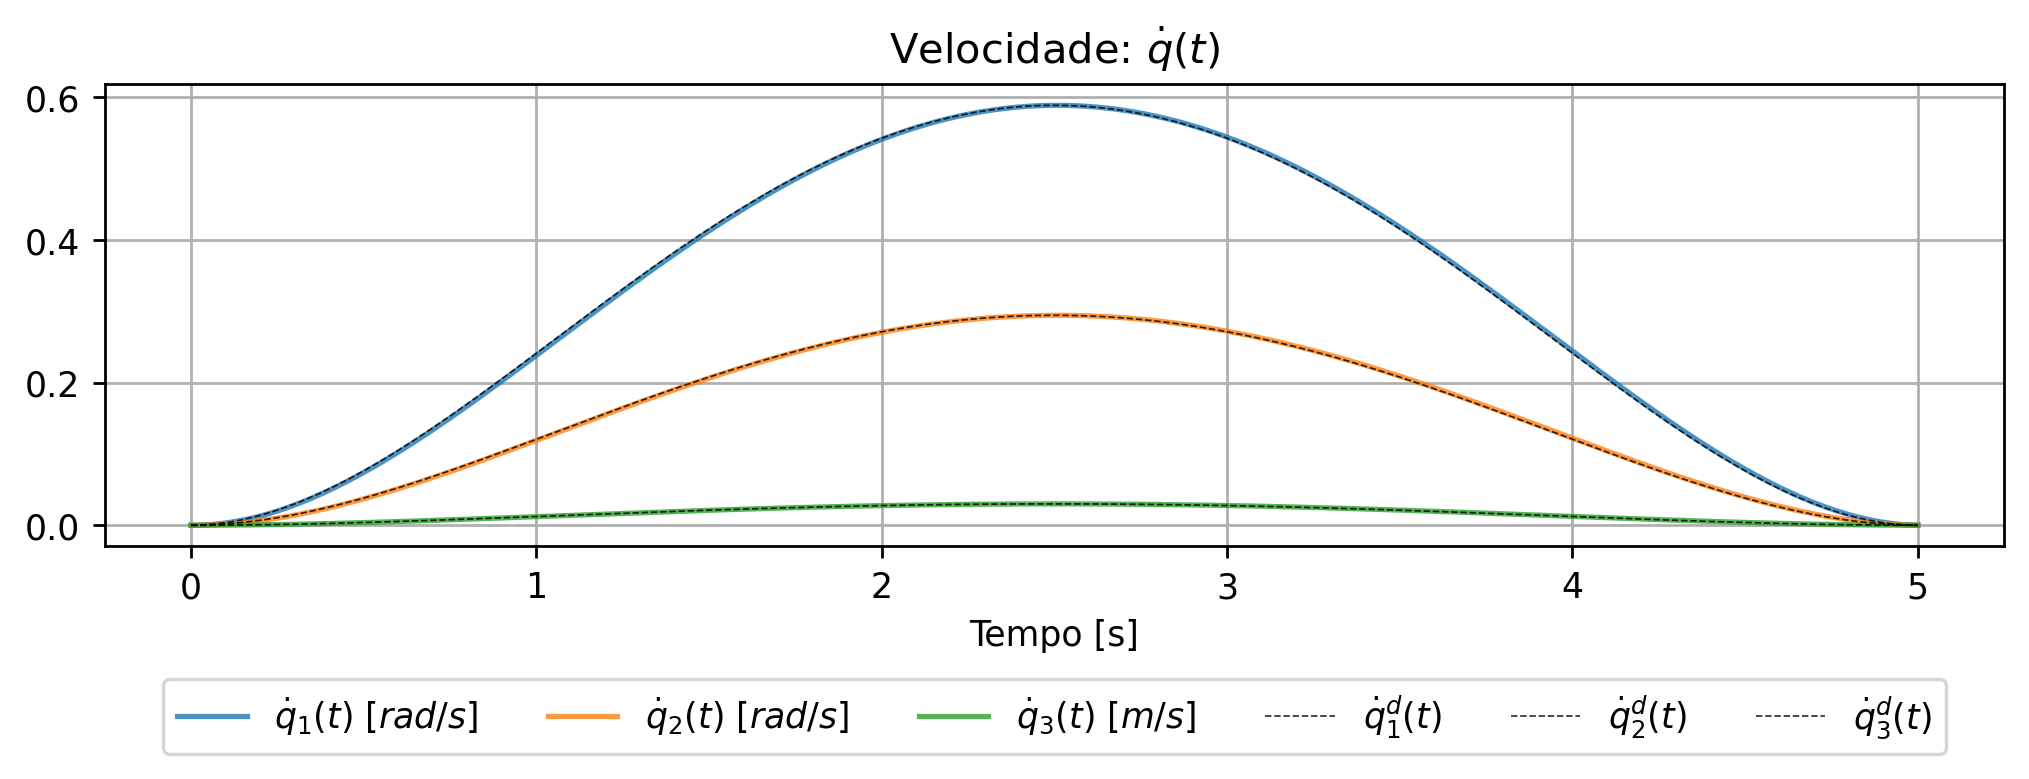

In [38]:
# Plot: Visualização única [todos em 1 gráfico]
plotar = 'dq'         # Pode ser 'q', 'dq', 'ddq', 'erro' ou 'tau'

data = {'q': q, 'dq': dq, 'ddq': ddq, 'erro': e, 'tau': tau}
data_d = {'q': q_ds, 'dq': dq_ds, 'ddq': ddq_ds}
title = {'q': 'Posição: $q(t)$', 
         'dq': 'Velocidade: $\\dot q(t)$', 
         'ddq': 'Aceleração: $\\ddot q(t)$', 
         'erro': 'Erro: $e(t) = q_d(t) - q(t)$', 
         'tau': 'Torque|Força: $\\tau(t)$'}
lbl = {'q': [f'$q_{i+1}(t)$' for i in range(r.dof)],
       'dq': [f'$\\dot q_{i+1}(t)$' for i in range(r.dof)],
       'ddq': [f'$\\ddot q_{i+1}(t)$' for i in range(r.dof)],
       'erro': [f'$e_{i+1}(t)$' for i in range(r.dof)],
       'tau': [f'$\\tau_{i+1}(t)$' for i in range(r.dof)]}
lbl_d = {'q': [f'$q_{i+1}^d(t)$' for i in range(r.dof)],
         'dq': [f'$\\dot q_{i+1}^d(t)$' for i in range(r.dof)],
         'ddq': [f'$\\ddot q_{i+1}^d(t)$' for i in range(r.dof)],
         'erro': [f'$e_{i+1}^d(t)$' for i in range(r.dof)],
         'tau': [f'$\\tau_{i+1}^d(t)$' for i in range(r.dof)]}
un = {'q': ['$[rad]$', '$[rad]$', '$[m]$'],
       'dq': ['$[rad/s]$', '$[rad/s]$', '$[m/s]$'],
       'ddq': ['$[rad/s^2]$', '$[rad/s^2]$', '$[m/s^2]$'],
       'erro': ['$[rad]$', '$[rad]$', '$[m]$'],
       'tau': ['$[N.m]$', '$[N.m]$', '$[N]$']}
ylbl = {k: [f'{lbl[k][i]} {un[k][i]}' for i in range(r.dof)] for k in lbl.keys()}


fig, ax = plt.subplots(figsize=(8, 3), dpi=250, layout='constrained')
ax.plot(tgrid, data[plotar], alpha=0.8, label=ylbl[plotar])
if plotar in ['q', 'dq', 'ddq']:
       ax.plot(tgrid, data_d[plotar], linestyle='--', color='k', lw=.5, label=lbl_d[plotar], alpha=.8)
ax.set_title(title[plotar])
ax.set_xlabel('Tempo [s]')
plt.grid()
ax.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=(2*r.dof if plotar in ['q', 'dq', 'ddq'] else r.dof))
colors = [ax.lines[i].get_color() for i in range(len(ax.lines))]


### Visualização separada

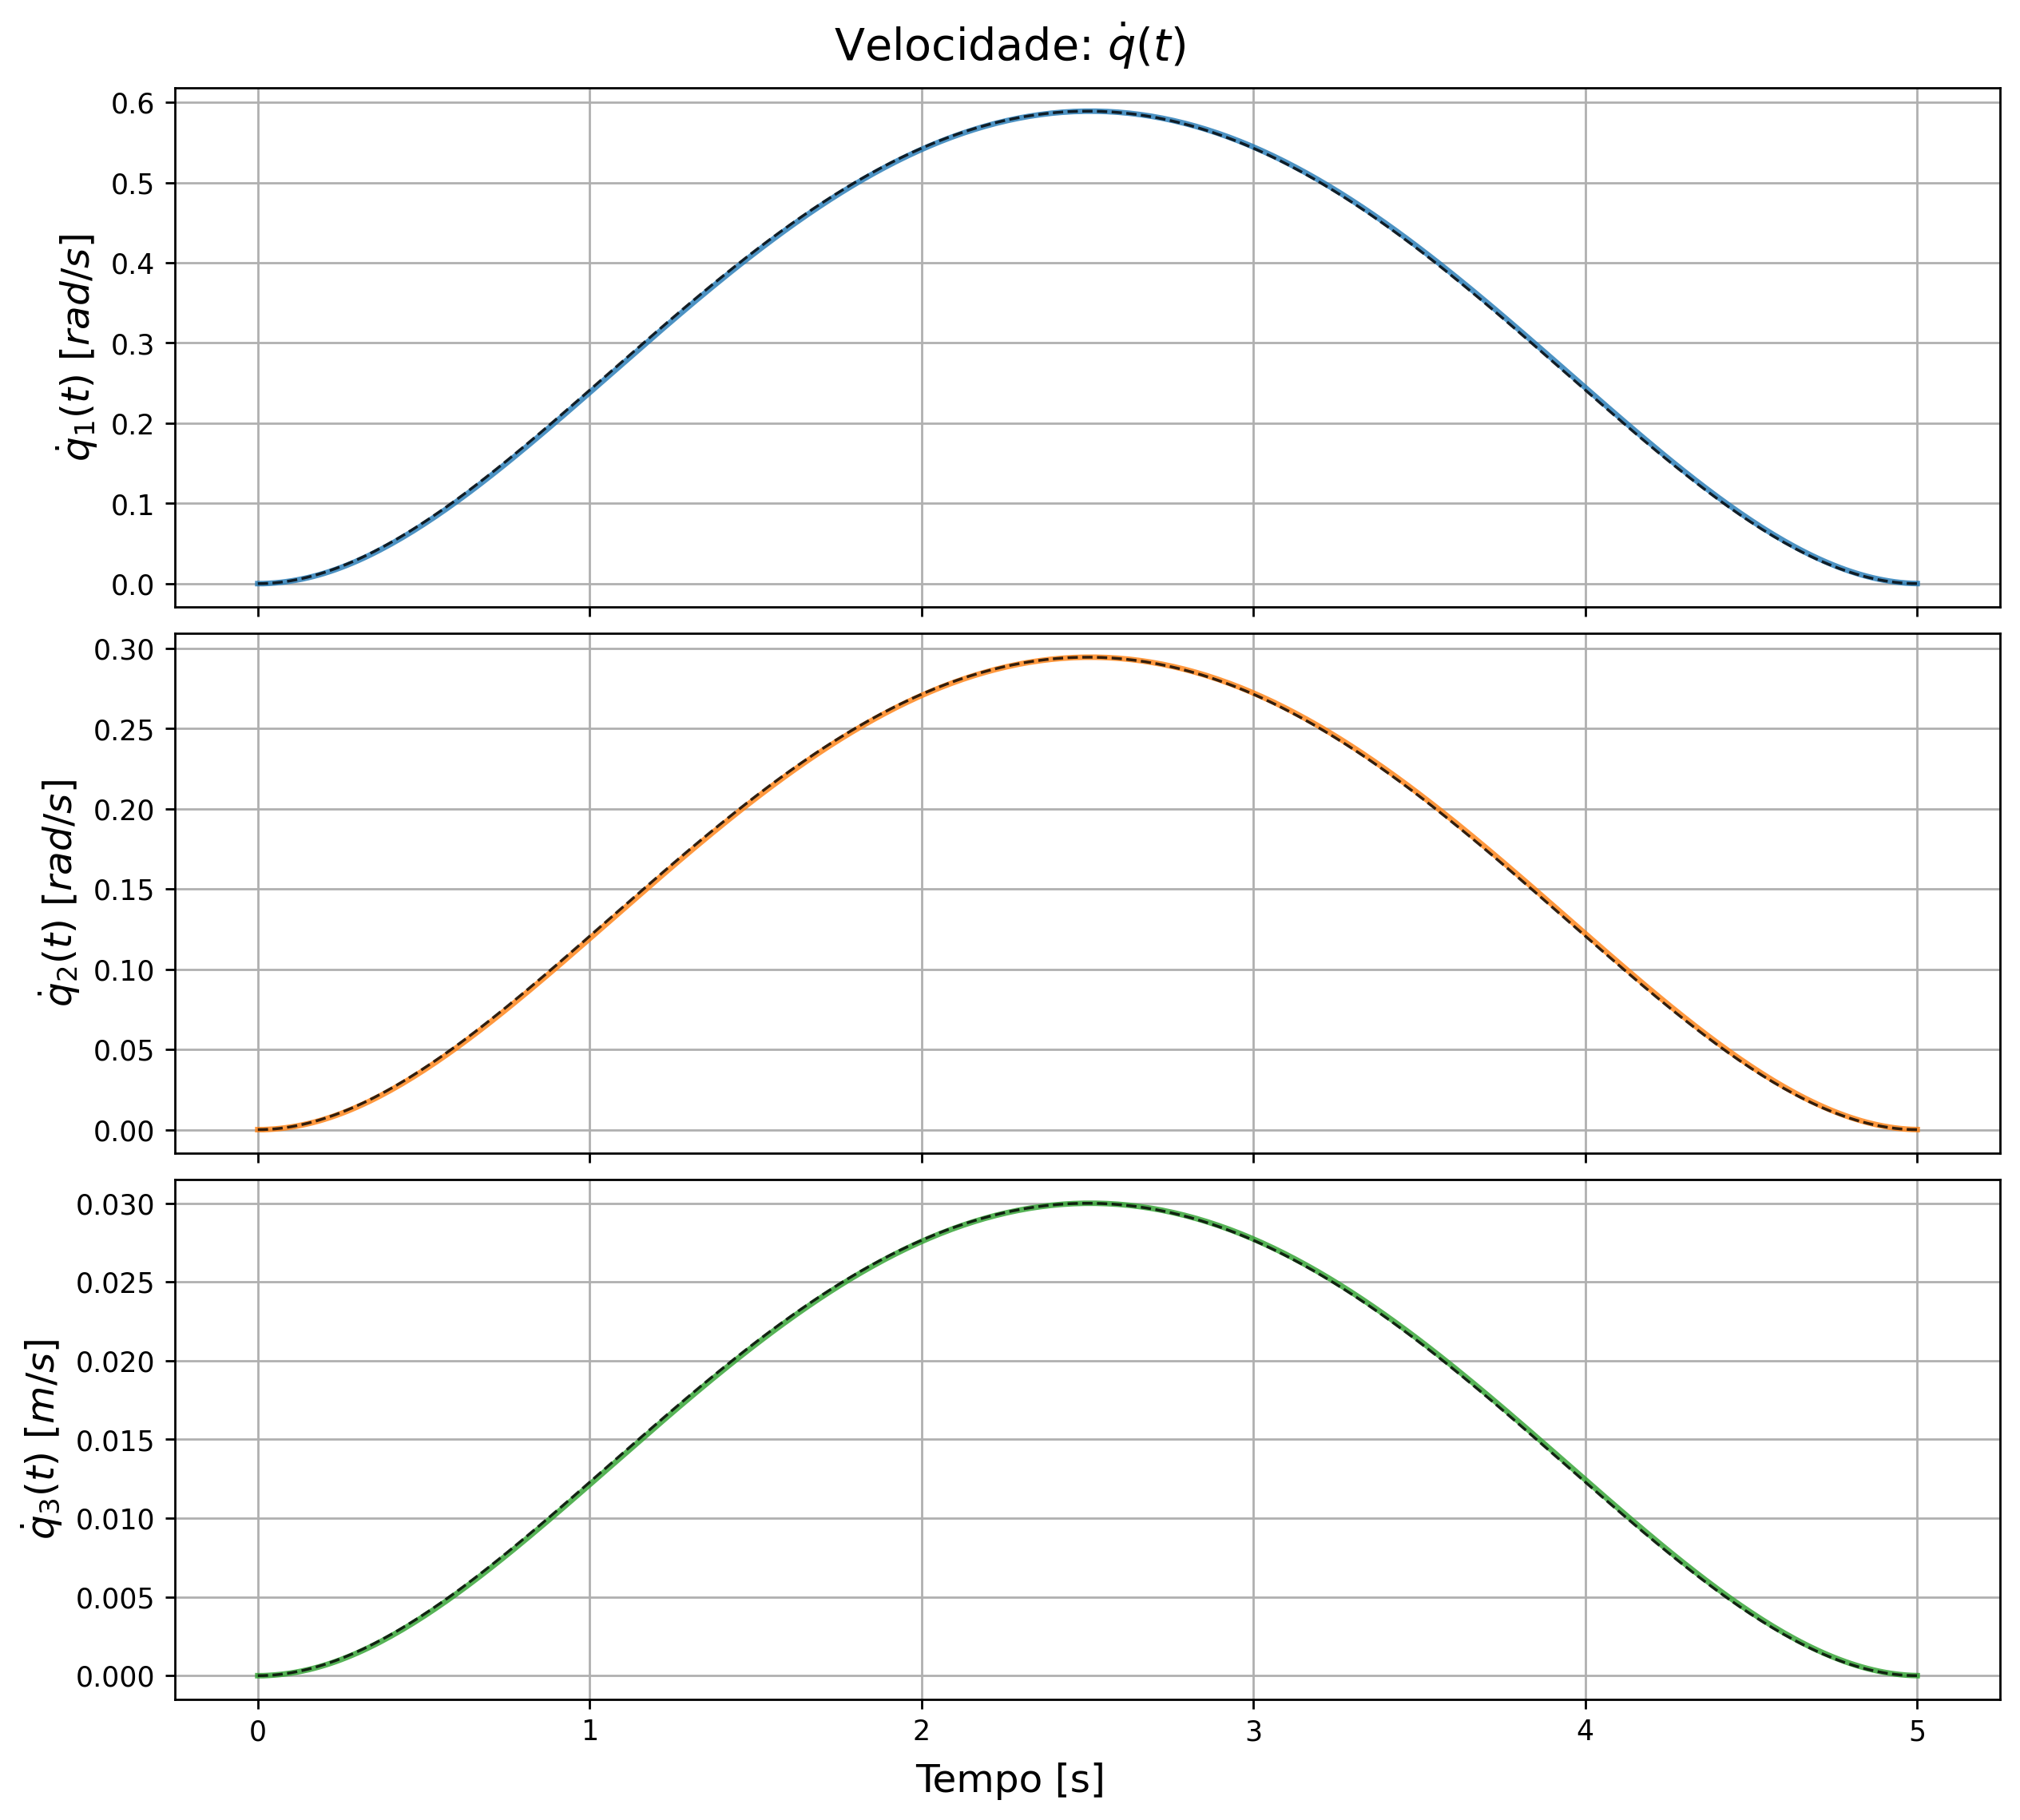

In [39]:
# Plot: Visualização separada [n gráficos]
# plotar = 'dq'         # Pode ser 'q', 'dq', 'ddq', 'erro' ou 'tau'

fig, axs = plt.subplots(3,1, figsize=(10,3*3), layout='constrained', sharex=True, dpi=250)
fig.suptitle(title[plotar], fontsize=16)
fig.supxlabel('Tempo [s]', fontsize=14)
for i, ax in enumerate(axs):
    ax.plot(tgrid, data[plotar].T[i], lw=2, label=lbl[plotar][i], alpha=.8, color=colors[i])
    if plotar in ['q', 'dq', 'ddq']:
       ax.plot(tgrid, data_d[plotar].T[i], linestyle='--', color='k', lw=1, label=lbl_d[plotar][i], alpha=.8)
    ax.set_ylabel(f'{lbl[plotar][i]} {un[plotar][i]}', fontsize=14)
    ax.grid()


### Visualização individual

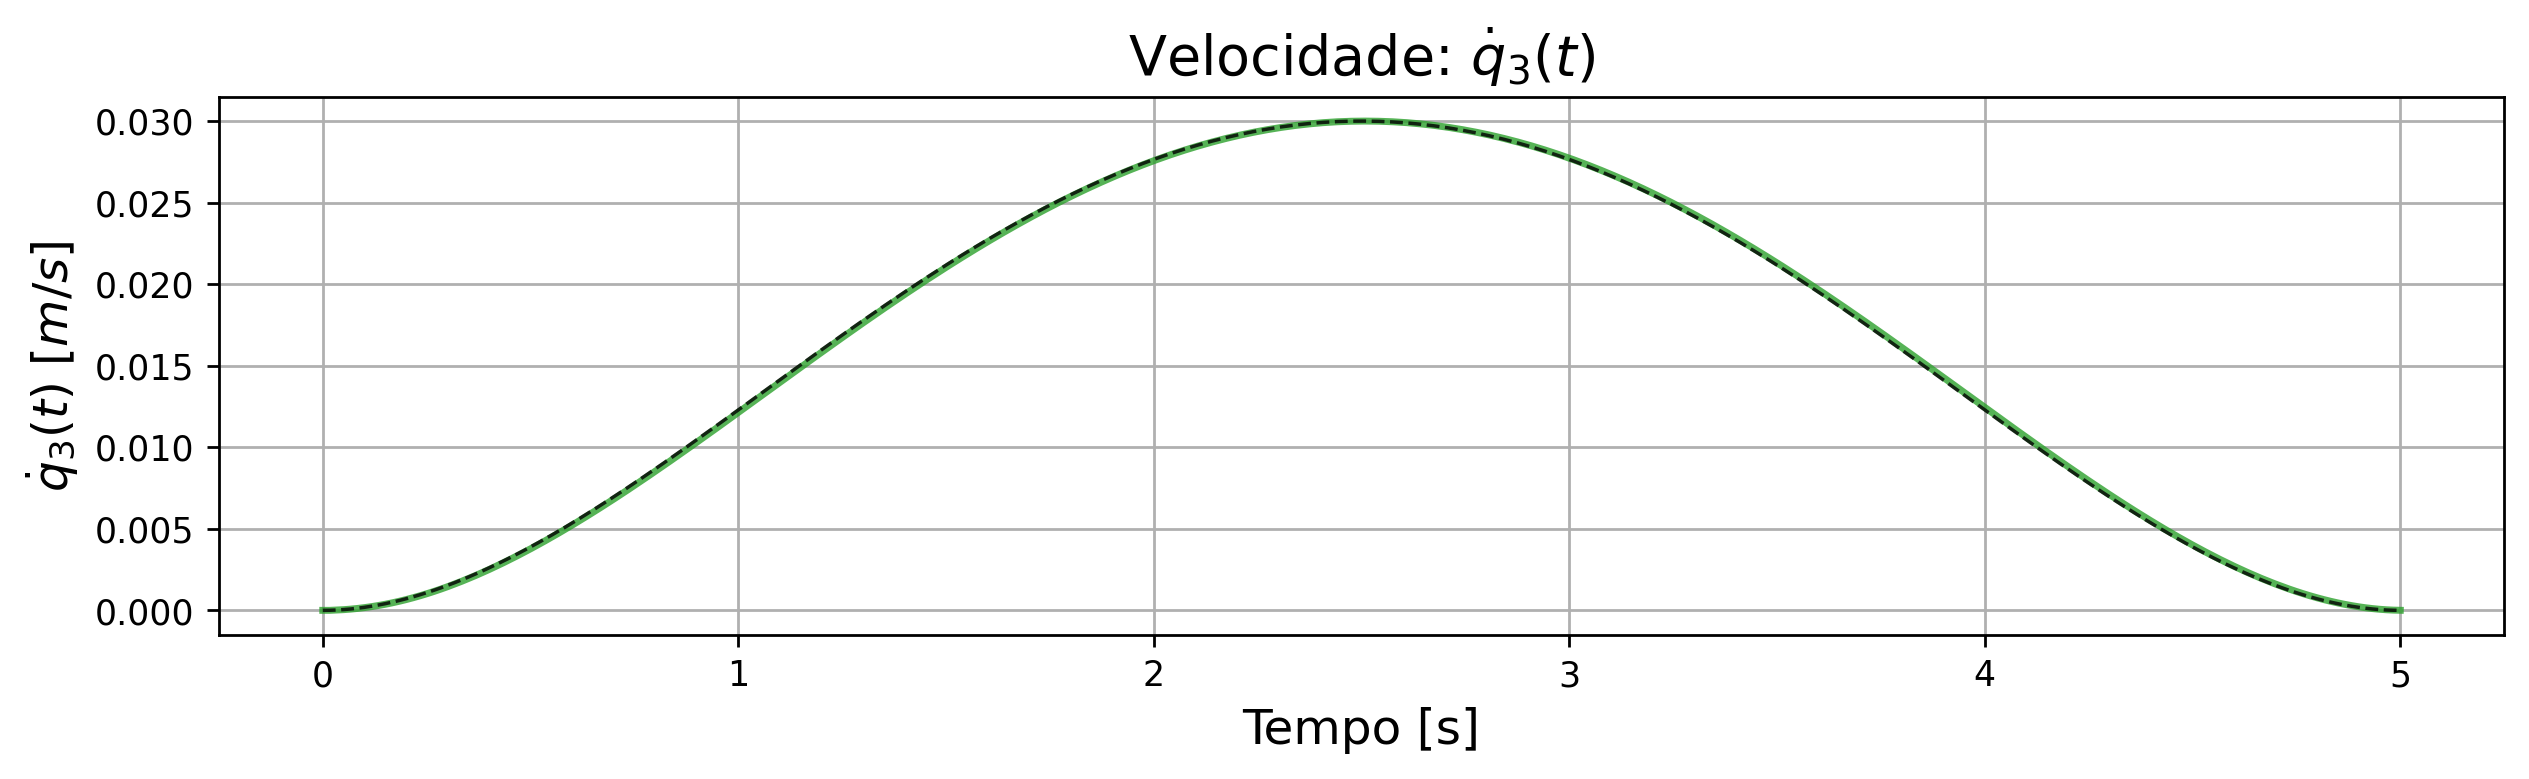

In [40]:
# Plot: Visualização individual
# plotar = 'dq'         # Pode ser 'q', 'dq', 'ddq', 'erro' ou 'tau'
i = 3                   # Junta a ser plotada (1, 2 ou 3)

i -= 1
fig, ax = plt.subplots(figsize=(10,3), layout='constrained', dpi=250)
ax.plot(tgrid, data[plotar].T[i], lw=2, alpha=.8, color=colors[i])
if plotar in ['q', 'dq', 'ddq']:
    ax.plot(tgrid, data_d[plotar].T[i], linestyle='--', color='k', lw=1, alpha=.8)
ax.set_title(f"{title[plotar][:title[plotar].find(':')]}: {lbl[plotar][i]}", fontsize=16)
ax.set_ylabel(f'{lbl[plotar][i]} {un[plotar][i]}', fontsize=14)
ax.set_xlabel('Tempo [s]', fontsize=14)
ax.grid()
